# Demographics of CD-16

In [15]:
import seaborn as sns
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import pyarrow
import fastparquet
import parquet as pq
from datetime import datetime, date

The data in this data is all sourced from [the national census](https://www.census.gov/), and filtered so that it would only include the two counties that we care about. Since there is not option to filter by congressional districts, since redistricting would probably create a lot of chaos, we will focus on county and city level intead.

## County Level

Please keep in mind that this data represents all citizens of each county, not just registered voters.

### Age

In [54]:
age_df = pd.read_csv("data/census/county_age.csv")

In [55]:
age_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 18 non-null     object
 1   San Mateo Total     18 non-null     object
 2   San Mateo Male      18 non-null     object
 3   San Mateo Female    18 non-null     object
 4   Santa Clara Total   18 non-null     object
 5   Santa Clara Male    18 non-null     object
 6   Santa Clara Female  18 non-null     object
dtypes: object(7)
memory usage: 1.1+ KB


In [56]:
sm = "San Mateo"
sc = "Santa Clara"
counties = [sm, sc]
cats = [" Total", " Male", " Female"]
valid = '1234567890.' #valid characters for a float
def sanitize(data):
    return float(''.join(filter(lambda char: char in valid, data)))
for county in counties:
    for cat in cats:
        age_df[county + cat] = age_df[county + cat].apply(sanitize)

<AxesSubplot:xlabel='Age'>

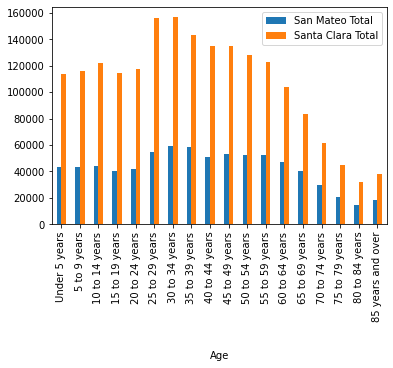

In [57]:
age_df.plot(x = "Age", y = ["San Mateo Total", "Santa Clara Total"], kind = "bar")

This bar graph plots the age distributions of the two counties and compares them side by side. As one can see, there is a mode for Santa Clara around **30-40 Years old**, while there are two smaller humps for San Mateo at **25-30 Years old** and **50-60 Years old**. These will be displayed more clearly when looking at each county by itself.

Another thing to notice is just how much *more* people live in Santa Clara than San Mateo. Ultimately, elections is a numbers game, so a strategy may be to just focus more on Santa Clara County.

### Education

In [39]:
ed_df = pd.read_csv("data/census/county_bachelors_condensed.csv")

In [40]:
ed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Field     20 non-null     object 
 1   Age       20 non-null     object 
 2   Estimate  20 non-null     float64
dtypes: float64(1), object(2)
memory usage: 608.0+ bytes


<AxesSubplot:xlabel='Field'>

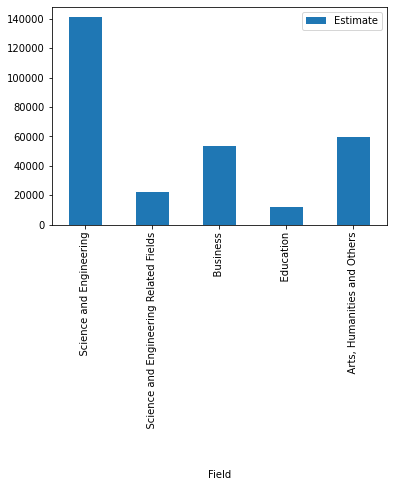

In [41]:
ed_df.iloc[15:21].plot(x = "Field", y = "Estimate", kind = "bar")
#for everyone in the county

As expected of Silicon Valley, **most citizens have a STEM-background**, with there being more people with a bachelor's in Science, Engineering, or a related field than all the other fields combined. This will probably influence how people perceive issues, as well as candidate solutions for said issues.

### Race

In [42]:
race_df = pd.read_csv("data/census/county_race.csv")

In [43]:
race_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 3 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Race                            7 non-null      object
 1   San Mateo County, California    7 non-null      int64 
 2   Santa Clara County, California  7 non-null      int64 
dtypes: int64(2), object(1)
memory usage: 296.0+ bytes


In [44]:
#race_df["San Mateo County, California"] = race_df["San Mateo County, California"].apply(sanitize)
#race_df["Santa Clara County, California"] = race_df["Santa Clara County, California"].apply(sanitize)

<AxesSubplot:xlabel='Race'>

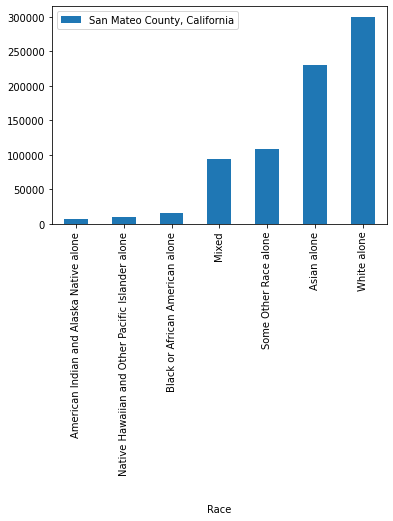

In [45]:
race_df.sort_values("San Mateo County, California").plot(x = "Race", y = "San Mateo County, California", kind = "bar")


<AxesSubplot:xlabel='Race'>

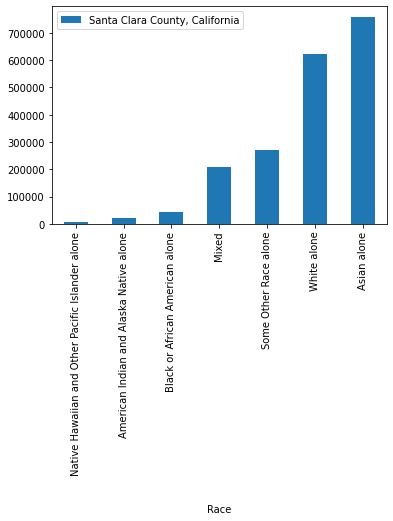

In [46]:
race_df.sort_values("Santa Clara County, California").plot(x = "Race", y = "Santa Clara County, California", kind = "bar")


It's interesting to note that **while San Mateo has a majority white population, Santa Clara has a majority asian population**, which may invite differing campaign strategies for each county in order to cater to the demographics.

## Only Registered Voters

In [16]:
smdf = pd.read_parquet("data/sanmateo.parquet")
smdf = smdf[smdf['DistrictID_1']=='CD-16']
smdf = smdf[['VoterID', 'ResidenceCity', 'BirthDate','Gender', 'PartyName']]
len(smdf.index)

82158

In [17]:
scdf = pd.read_csv("data/Santa_Clara_Voter_Data.csv", dtype = {'sSitusZip': 'string', 'sHouseNum': 'string'})
scdf = scdf[['lVoterUniqueID', 'szSitusCity', 'dtBirthDate', 'sGender', 'szPartyName']]
scdf = scdf.rename(columns = {'lVoterUniqueID': 'VoterID', 'szSitusCity': 'ResidenceCity', 'dtBirthDate': 'BirthDate', 
                              'sGender': 'Gender', 'szPartyName': 'PartyName'})
scdf.head()

,VoterID,ResidenceCity,BirthDate,Gender,PartyName
0,70633,San Jose,12/12/1959,NaN,Democratic
1,1009844,San Jose,7/3/1969,NaN,Democratic
2,2569637,San Jose,12/19/1982,NaN,No Party Preference
3,2900985,San Jose,3/24/1978,NaN,American Independent
4,2185012,San Jose,1/11/1988,NaN,Democratic


In [18]:
frames = [smdf, scdf]
cddf = pd.concat(frames)
cddf.reset_index(drop = True, inplace = True)

In [19]:
cddf.index.is_unique

True

# District Level

### Party Leaning

<AxesSubplot:>

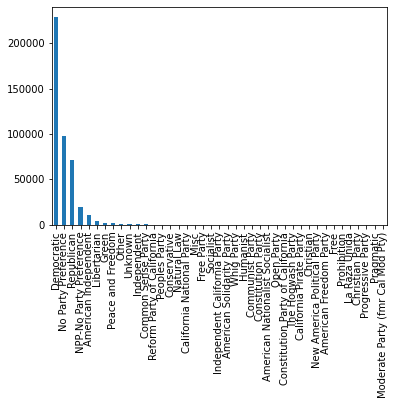

In [20]:
fig, ax = plt.subplots()
cddf['PartyName'].value_counts().plot(ax=ax, kind='bar')

As expected, California is very heavily Democratic, with No Party Preference being the second most frequent, and then folowed by Republican.

### Gender

<AxesSubplot:>

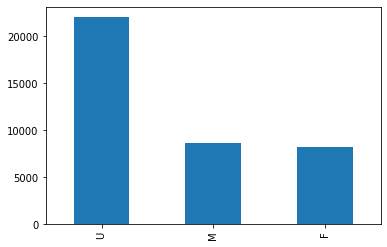

In [21]:
fig, ax2 = plt.subplots()
cddf['Gender'].value_counts().plot(ax=ax2, kind='bar')

Since most of the genders are unknown, it would probably be best to take this data with a grain of salt. However, based on who *did* respond, there is almost an even divide between male and female voters.

### Age

<AxesSubplot:xlabel='Count', ylabel='Age'>

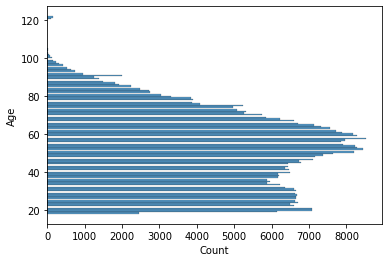

In [22]:
#fig, ax3 = plt.subplots()
def age(row):
    born = row['BirthDate']
    born = datetime.strptime(born, "%m/%d/%Y").date()
    today = date.today()
    return today.year - born.year - ((today.month, 
                                      today.day) < (born.month, 
                                                    born.day))
cddf['Age'] = cddf.apply(lambda row: age(row), axis = 1)
sns.histplot(data = cddf, y = "Age")
#plt.show()

The two bump previously mentioned appear again! This is because Santa Clara has a much larger population, so its data patterns, in a sense, "overwrite" those of San Mateo when put together.

# County Level 

## San Mateo

Voter turnout was 38.40%. voter registration rate was 56.54% (data from 6/23 primary election data, gooogle). 

#### Party Leaning

<AxesSubplot:>

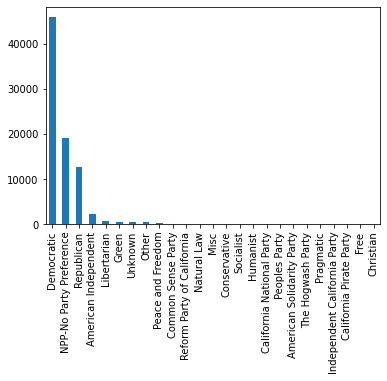

In [23]:
fig, sm = plt.subplots()
smdf['PartyName'].value_counts().plot(ax=sm, kind='bar')

#### Gender

<AxesSubplot:>

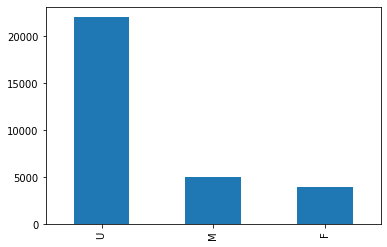

In [24]:
fig, sm2 = plt.subplots()
smdf['Gender'].value_counts().plot(ax=sm2, kind='bar')

#### Age

<AxesSubplot:xlabel='Count', ylabel='Age'>

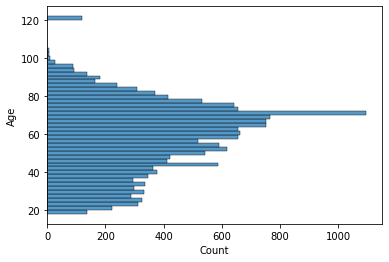

In [25]:
smdf['Age'] = smdf.apply(lambda row: age(row), axis = 1)
sns.histplot(data = smdf2, y = "Age")

## Santa Clara

Voter turnout was 35.70%. Voter registration was 52.7% (Numbers from 6/28 data, google.)

#### Party Leaning

<AxesSubplot:>

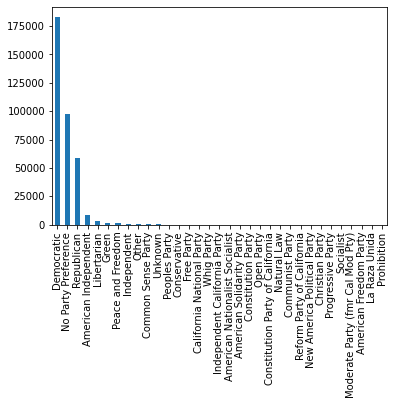

In [24]:
fig, sc = plt.subplots()
scdf['PartyName'].value_counts().plot(ax=sc, kind='bar')

#### Gender

<AxesSubplot:>

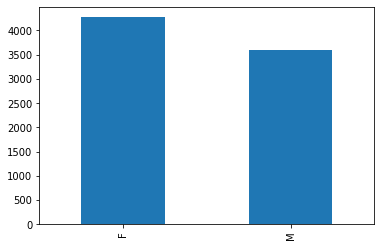

In [25]:
fig, sc2 = plt.subplots()
scdf['Gender'].value_counts().plot(ax=sc2, kind='bar')

#### Age

<AxesSubplot:xlabel='Count', ylabel='Age'>

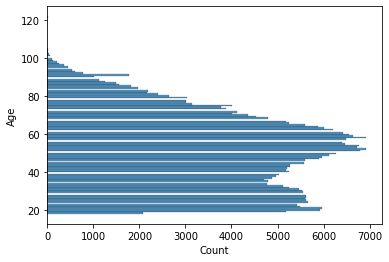

In [26]:
scdf['Age'] = scdf.apply(lambda row: age(row), axis = 1)
sns.histplot(data = scdf, y = "Age")

# City Level

In [27]:
smcities = pd.unique(smdf['ResidenceCity'])
sccities = pd.unique(scdf['ResidenceCity'])
print(smcities)
print(sccities)

['Menlo Park' 'Montara' 'Atherton' 'Half Moon Bay' 'Redwood City'
 'Pacifica' 'Woodside' 'Portola Valley' 'El Granada' 'La Honda'
 'Moss Beach' 'Pescadero' 'San Gregorio' 'Princeton' 'Loma Mar'
 'Burlingame']
['San Jose' 'Los Gatos' 'Saratoga' 'Campbell' 'Mountain View'
 'Monte Sereno' 'Los Altos' 'Palo Alto' 'Los Altos Hills' 'Stanford'
 'Redwood Estates' 'Portola Valley' 'Cupertino' 'Moffett Field'
 'Sunnyvale']


Too much work to do every city, so will create a a script where you can just change the city you want and get the data for it.

In [28]:
city = 'Menlo Park'
idx = -1
if city in smcities:
    idx = 0
elif city in sccities:
    idx = 1

if(idx >-1):
    citydf = frames[idx]
    citydf = citydf[citydf['ResidenceCity']==city]
    citydf.reset_index(drop = True, inplace = True)
else:
    print("City Does Not Exist! Please Try Again.")

<AxesSubplot:>

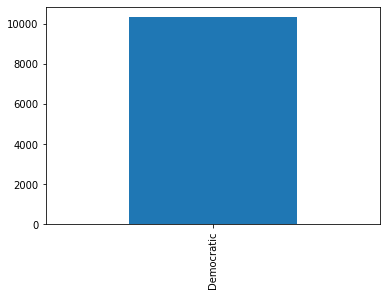

In [29]:
fig, ct = plt.subplots()
citydf['PartyName'].value_counts().plot(ax=ct, kind='bar')

<AxesSubplot:>

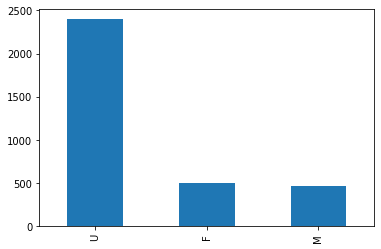

In [30]:
fig, ct2 = plt.subplots()
citydf['Gender'].value_counts().plot(ax=ct2, kind='bar')

C:\Users\super\AppData\Local\Temp\ipykernel_24924\3356103587.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  citydf['Age'] = citydf.apply(lambda row: age(row), axis = 1)


<AxesSubplot:xlabel='Count', ylabel='Age'>

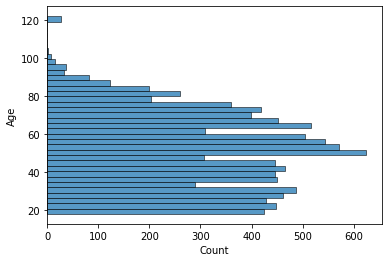

In [31]:
citydf['Age'] = citydf.apply(lambda row: age(row), axis = 1)
sns.histplot(data = citydf, y = "Age")